In [1]:
import os
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import ancillary as ac
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import hdmedians as hd
from utils import correlation, age_regression, sex_classification, plot_sq
from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment

In [2]:
ukb_smri_data_path = "/Users/xli77/Dropbox (GaTech)/MIVA/output/UKB_MMIVA_C30_preregSite_SMRI_MancovanOuts_wX_FINAL.mat"
ukb_smri_data = sio.loadmat(ukb_smri_data_path)['MODELUKB0s_ful']
ukb_smri_data_array = ukb_smri_data[0][0][0]
ukb_smri_data_key = np.squeeze(ukb_smri_data[0][0][3])
age_idx = np.where(ukb_smri_data_key==['age_when_attended_assessment_centre_f21003_2_0'])[0][0]
sex_idx = np.where(ukb_smri_data_key==['sex_f31_0_0'])[0][0]
age = ukb_smri_data_array[:, age_idx]
sex = ukb_smri_data_array[:, sex_idx]

In [3]:
datapath="/Users/xli77/Dropbox (GaTech)/MISA/results/SIVA/fixedSubspace/um2mm/seed7_snr1000"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

Y = np.zeros((num_subspace_struct,3,2,12,2907)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
W = np.zeros((num_subspace_struct,3,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

num_iter=21
corr = np.zeros((num_subspace_struct,9,12,12))

for i,ss in enumerate(subspace_struct_list):

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_Y.mat"))
    Y1=np.squeeze(data['Y1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_Y.mat"))
    Y2=np.squeeze(data['Y2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_Y.mat"))
    Y3=np.squeeze(data['Y3'])

    Y[i,0,0]=Y1[0]
    Y[i,0,1]=Y1[1]
    Y[i,1,0]=Y2[0]
    Y[i,1,1]=Y2[1]
    Y[i,2,0]=Y3[0]
    Y[i,2,1]=Y3[1]

    # for j in range(2):
    #     for k in range(2):
    #         for l in range(12):
    #             sgn = np.sign(correlation(Y[i,j,k,l],age))
    #             Y[i,j,k,l] = -sgn * Y[i,j,k,l]

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_W.mat"))
    W1=np.squeeze(data['W1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_W.mat"))
    W2=np.squeeze(data['W2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_W.mat"))
    W3=np.squeeze(data['W3'])

    W[i,0,0]=W1[0]
    W[i,0,1]=W1[1]
    W[i,1,0]=W2[0]
    W[i,1,1]=W2[1]
    W[i,2,0]=W3[0]
    W[i,2,1]=W3[1]

    corr[i,0] = np.corrcoef(Y1[0],Y1[0])[:12,:12]
    corr[i,1] = np.corrcoef(Y1[1],Y1[1])[:12,:12]
    corr[i,2] = np.corrcoef(Y1[0],Y1[1])[12:,:12]

    corr[i,3] = np.corrcoef(Y2[0],Y2[0])[:12,:12]
    corr[i,4] = np.corrcoef(Y2[1],Y2[1])[:12,:12]
    corr[i,5] = np.corrcoef(Y2[0],Y2[1])[12:,:12]

    corr[i,6] = np.corrcoef(Y3[0],Y3[0])[:12,:12]
    corr[i,7] = np.corrcoef(Y3[1],Y3[1])[:12,:12]
    corr[i,8] = np.corrcoef(Y3[0],Y3[1])[12:,:12]

In [4]:
val = 1
num_source = 12

# S1
num_unique_source = 3
s1 = np.zeros((num_source, num_source))
s1[:2,:2] = val
s1[2:5,2:5] = val*2
s1[5:9,5:9] = val*3

# S2
num_unique_source = 2
s2 = np.zeros((num_source, num_source))
s2[:2,:2] = val
s2[2:4,2:4] = val*2
s2[4:6,4:6] = val*3
s2[6:8,6:8] = val*4
s2[8:10,8:10] = val*5

# S3
num_unique_source = 3
s3 = np.zeros((num_source, num_source))
s3[:3,:3] = val
s3[3:6,3:6] = val*2
s3[6:9,6:9] = val*3

# S4
num_unique_source = 4
s4 = np.zeros((num_source, num_source))
s4[:4,:4] = val
s4[4:8,4:8] = val*2

# S5
num_unique_source = 4
s5 = np.zeros((num_source, num_source))
for i in range(12):
    s5[i,i] = val*(i+1)

s_list = [s1, s2, s3, s4, s5]

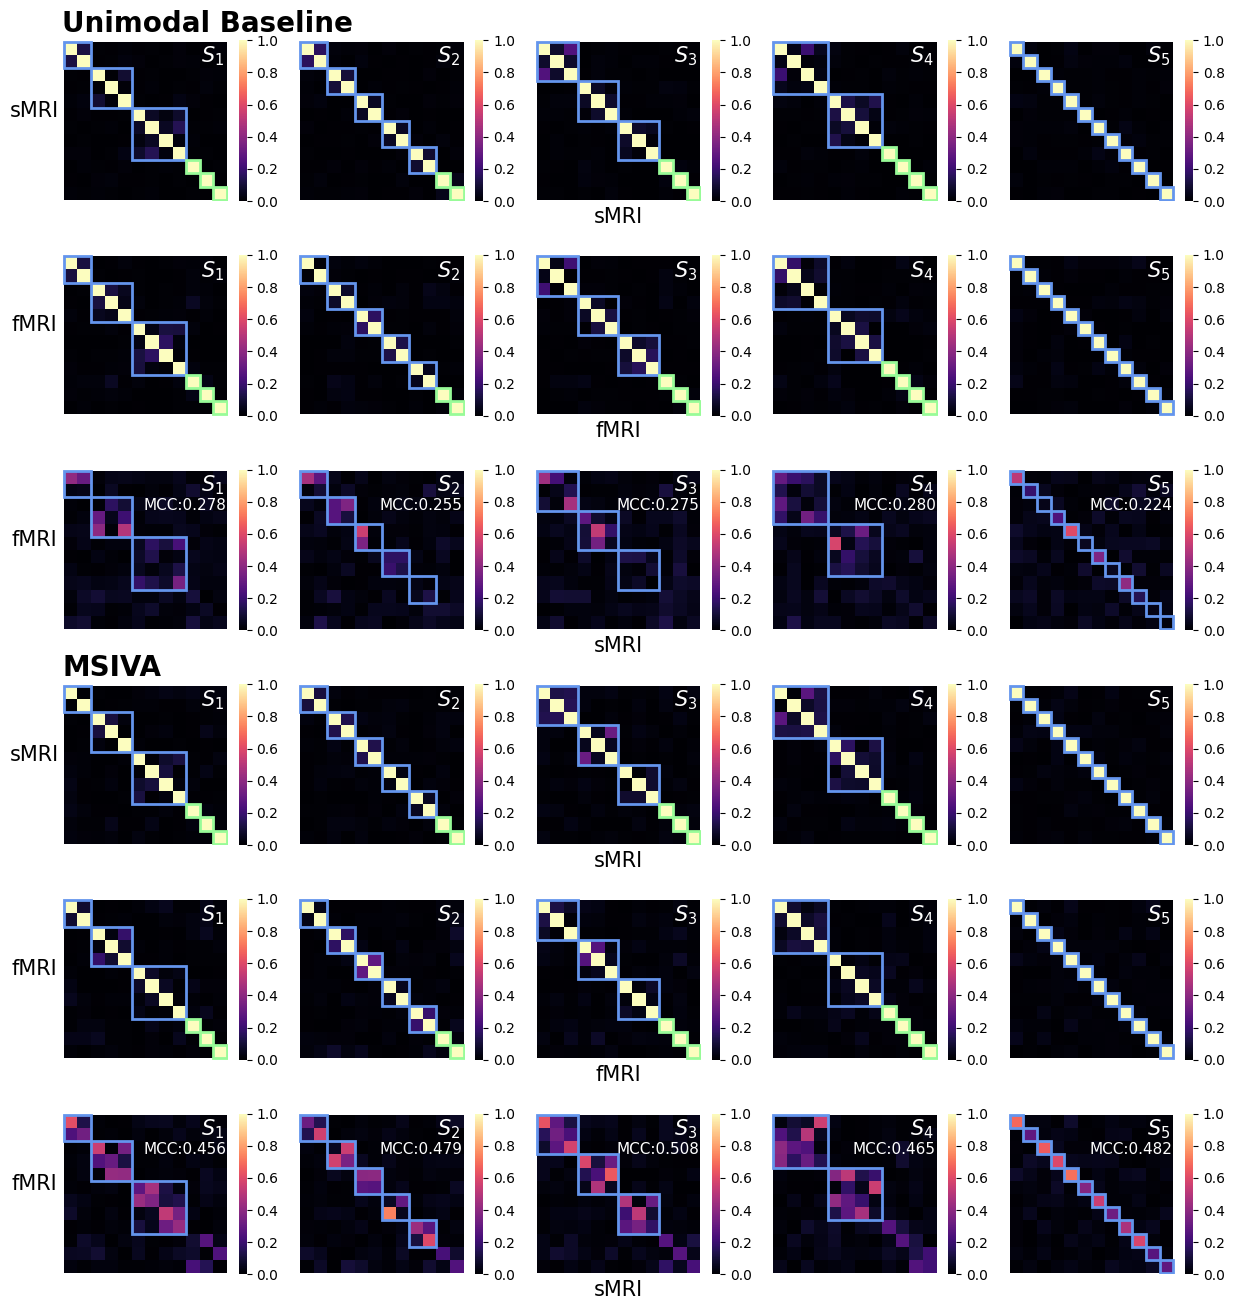

In [6]:
analysis_list = ["Unimodal Baseline"]*3+["MSIVA"]*3
modality_list = ["sMRI", "fMRI"]
subspace_dict = {"S1": [2, 3, 4], "S2": [2, 2, 2, 2, 2], "S3": [3, 3, 3], "S4": [4, 4], "S5": [1]*12}

fig, axes = plt.subplots(6,num_subspace_struct,figsize=(2.5*num_subspace_struct,2.2*6))

for i in range(num_subspace_struct):
    ss = subspace_dict[f"S{i+1}"]
    for j in range(6):
        ax = axes[j,i]
        if j == 2 or j == 5:
            abscorr = np.abs(corr[i,j])
            abscorr_subspace_list = []
            for k, d in enumerate(ss):
              ind_start = sum(ss[:k])
              abscorr_subspace = abscorr[ind_start:ind_start+d,ind_start:ind_start+d]
              maxrow = np.max(abscorr_subspace, axis=1)
              maxcol = np.max(abscorr_subspace, axis=0)
              mean_corr = np.sum((maxrow, maxcol))/(2*d)
              abscorr_subspace_list.append(mean_corr)
            mcc = np.mean(abscorr_subspace_list)
            sns.heatmap(np.abs(corr[i,j]),cmap="magma",vmin=0,vmax=1,ax=ax)
            ax.text(10.9, 1.1, f"$S_{i+1}$", fontsize=15, color="white", ha="center", va="center")
            ax.text(8.9, 2.6, f"MCC:{mcc:.3f}", fontsize=11, color="white", ha="center", va="center")
            if i == 2:
              ax.set_xlabel("sMRI",fontsize=15)
            if i == 0:
              ax.set_ylabel("fMRI",fontsize=15,rotation=0,labelpad=20)
            plot_sq(ax, i, crossmodal=True)
            ax.set_xlim(-0.1, 12.1)
            ax.set_ylim(12.1, -0.1)
        else:
            mcc = np.mean(np.diag(np.abs(corr[i,j])))
            sns.heatmap(np.abs(corr[i,j]),cmap="magma",vmin=0,vmax=1,ax=ax)
            ax.text(10.9, 1.1, f"$S_{i+1}$", fontsize=15, color="white", ha="center", va="center")
            # ax.text(9, 2.6, f"MCC:{mcc:.3f}", fontsize=11, color="white", ha="center", va="center")
            if i == 2:
               ax.set_xlabel(f"{modality_list[j%3]}",fontsize=15)
            if i == 0:
              ax.set_ylabel(f"{modality_list[j%3]}",fontsize=15,rotation=0,labelpad=20)
            plot_sq(ax, i)
            ax.set_xlim(-0.1, 12.1)
            ax.set_ylim(12.1, -0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0 and j == 0:
            ax.set_title(analysis_list[j],loc="left",fontsize=20,fontweight="bold")
        if i == 0 and j == 3:
            ax.set_title(analysis_list[j],loc="left",fontsize=20,fontweight="bold")

plt.tight_layout()
plt.savefig("neuroimaging_ukb.pdf")

In [7]:
num_iter=21
loss_um=np.zeros((num_subspace_struct,num_iter))
loss_ummm=np.zeros((num_subspace_struct,num_iter))
loss_mm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_um'][2,:])
        loss_um[i,:] = a
    else:
        a = np.squeeze(data['aux_um'][1,:])
        loss_um[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_ummm'][2,:])
        loss_ummm[i,:] = a
    else:
        a = np.squeeze(data['aux_ummm'][1,:])
        loss_ummm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_mm'][2,:])
        loss_mm[i,:] = a
    else:
        a = np.squeeze(data['aux_mm'][1,:])
        loss_mm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_70743/3902918593.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_um[i,:] = a
/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_70743/3902918593.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_ummm[i,:] = a
/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_70743/3902918593.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_mm[i,:] = a


In [8]:
loss_um_min = np.min(loss_um,axis=1)
loss_ummm_min = np.min(loss_ummm,axis=1)
loss_mm_min = np.min(loss_mm,axis=1)

print(np.round(loss_um_min,3))
print(np.round(loss_ummm_min,3))
print(np.round(loss_mm_min,3))

[47.735 47.811 47.768 47.778 47.999]
[46.794 46.775 46.798 46.892 46.924]
[30.817 30.882 30.794 31.096 30.871]


In [9]:
A = sio.loadmat("/Users/xli77/GaTech Dropbox/Xinhui Li/MISA/results/SIVA/fixedSubspace/mask/A.mat")["A"]

WAY_list = []
cca_corr_list = []

for i in np.arange(0,10,2):
    # S1-4, UA/MSIVA, M1-2, voxel, source
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2
    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 
    AY1 = A1@Y1
    AY2 = A2@Y2

    # PCA AY1, AY2
    AY1_p, AY1_p_projM, AY1_p_projM_std = ac.base_PCA(AY1, num_PC=None, axis=-2, whitening=True)
    AY2_p, AY2_p_projM, AY2_p_projM_std = ac.base_PCA(AY2, num_PC=None, axis=-2, whitening=True)

    # Post-PCA eigenvalue problem for CCA
    S12 = AY1_p @ AY2_p.T
    Z1 = np.zeros((AY1_p.shape[0],AY1_p.shape[0]), dtype=AY1_p.dtype)
    Z2 = np.zeros((AY2_p.shape[0],AY2_p.shape[0]), dtype=AY2_p.dtype)
    J = np.block([[Z1, S12],[S12.T, Z2]])
    U, S = ac.do_cov_EVD(J, k=2) # here, k = smallest subspace size in each modality

    # Final transformations: these multiply AY
    W1 = U[:2,].T @ AY1_p_projM
    W2 = U[2:,].T @ AY2_p_projM

    WAY1 = W1 @ AY1
    WAY2 = W2 @ AY2
    WAY_list.append( [WAY1, WAY2] )

    cca_corr = np.corrcoef(WAY1, WAY2)[2:,0:2]
    cca_corr_list.append(cca_corr)

In [10]:
num_voxel = A.shape[3]
num_crossmodal_subspace = 5
voxelwise_cca_corr = np.zeros((num_crossmodal_subspace, num_voxel))

for j, i in enumerate(np.arange(0,10,2)):
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2
    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 
    AY1 = A1@Y1
    AY2 = A2@Y2
    for k in range(num_voxel):
        AY1_voxel = np.expand_dims(AY1[k, :], axis=0)
        AY2_voxel = np.expand_dims(AY2[k, :], axis=0)

        # PCA AY1, AY2
        AY1_p, AY1_p_projM, AY1_p_projM_std = ac.base_PCA(AY1_voxel, num_PC=None, axis=-2, whitening=True)
        AY2_p, AY2_p_projM, AY2_p_projM_std = ac.base_PCA(AY2_voxel, num_PC=None, axis=-2, whitening=True)

        # Post-PCA eigenvalue problem for CCA
        S12 = AY1_p @ AY2_p.T
        Z1 = np.zeros((AY1_p.shape[0],AY1_p.shape[0]), dtype=AY1_p.dtype)
        Z2 = np.zeros((AY2_p.shape[0],AY2_p.shape[0]), dtype=AY2_p.dtype)
        J = np.block([[Z1, S12], [S12.T, Z2]])
        U, S = ac.do_cov_EVD(J, k=2) # here, k = smallest subspace size in each modality

        # Final transformations: these multiply AY
        W1 = U[:1,].T @ AY1_p_projM
        W2 = U[1:,].T @ AY2_p_projM
        WAY1 = W1 @ AY1_voxel
        WAY2 = W2 @ AY2_voxel
        voxelwise_cca_corr[j, k] = np.corrcoef(WAY1, WAY2)[2:,0:2][0,0]

# sio.savemat("voxelwise_cca_corr_ukb.mat", {"corr": voxelwise_cca_corr})

/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_68950/1855736347.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


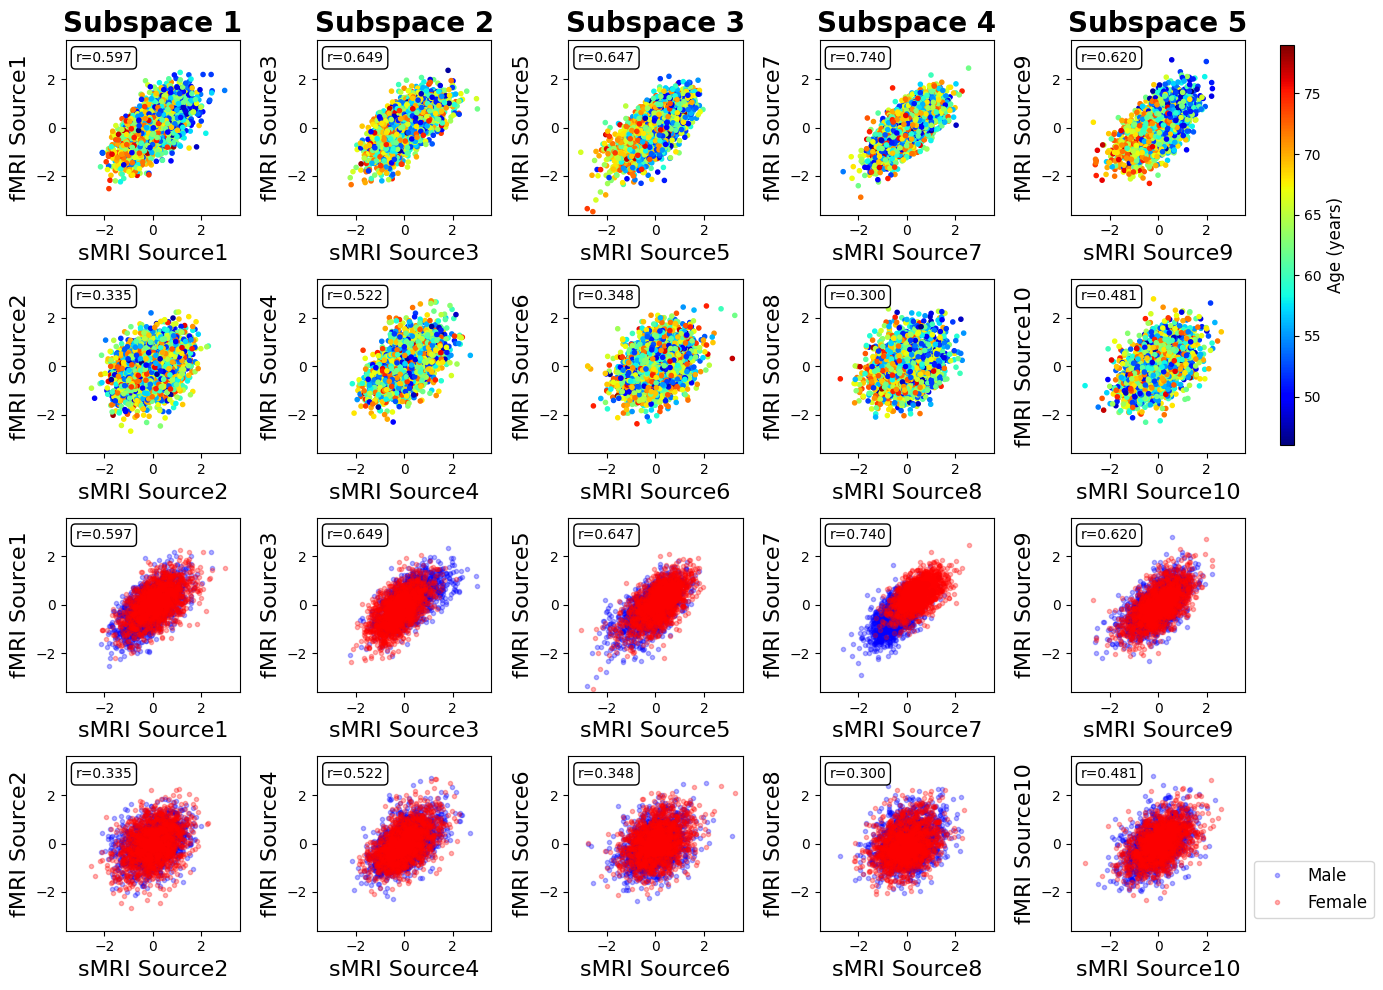

In [19]:
cmap = plt.cm.jet
norm = Normalize(vmin=age.min(), vmax=age.max())

scv_list = []
for i in np.arange(0,10,2):
    scv_list.append([f"Source{i+1}", f"Source{i+2}"])

lim = 3.6
fig, axes = plt.subplots(4,5,figsize=(14,10))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]
        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
        axes[i,k].set_aspect('equal', 'box')
        axes[i,k].set_xlabel(f'sMRI {scv_list[k][i]}', fontsize=16)
        axes[i,k].set_ylabel(f'fMRI {scv_list[k][i]}', fontsize=16)
        axes[i,k].set_xlim([-lim,lim])
        axes[i,k].set_ylim([-lim,lim])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        axes[i,k].annotate(f'r={r}', xy=(48, 118), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
        age_subplot = axes[i,k].scatter(WAY1[i], WAY2[i], c=age, cmap=cmap, norm=norm, marker='.', alpha=1)
        axes[i+2,k].plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3,label='Male')
        axes[i+2,k].plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3,label='Female')
        axes[i+2,k].set_aspect('equal', 'box')
        axes[i+2,k].set_xlabel(f'sMRI {scv_list[k][i]}', fontsize=16)
        axes[i+2,k].set_ylabel(f'fMRI {scv_list[k][i]}', fontsize=16)
        axes[i+2,k].set_xlim([-lim,lim])
        axes[i+2,k].set_ylim([-lim,lim])
        axes[i+2,k].annotate(f'r={r}', xy=(48, 118), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
        if i == 0:
            axes[i,k].set_title(f"Subspace {k+1}", fontsize=20, fontweight="bold")

cbar_ax = fig.add_axes([0.92, 0.55, 0.01, 0.4])
cbar = plt.colorbar(age_subplot, cax=cbar_ax)
cbar.set_label('Age (years)', fontsize=12)
cbar.ax.tick_params(labelsize=10)
axes[3,4].legend(bbox_to_anchor=(1, 0.45), fontsize=12)

plt.tight_layout()
# plt.savefig("figures/cca_age_sex.pdf")
# plt.savefig("figures/cca_age_sex.png", dpi=500)

/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_35878/263541708.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


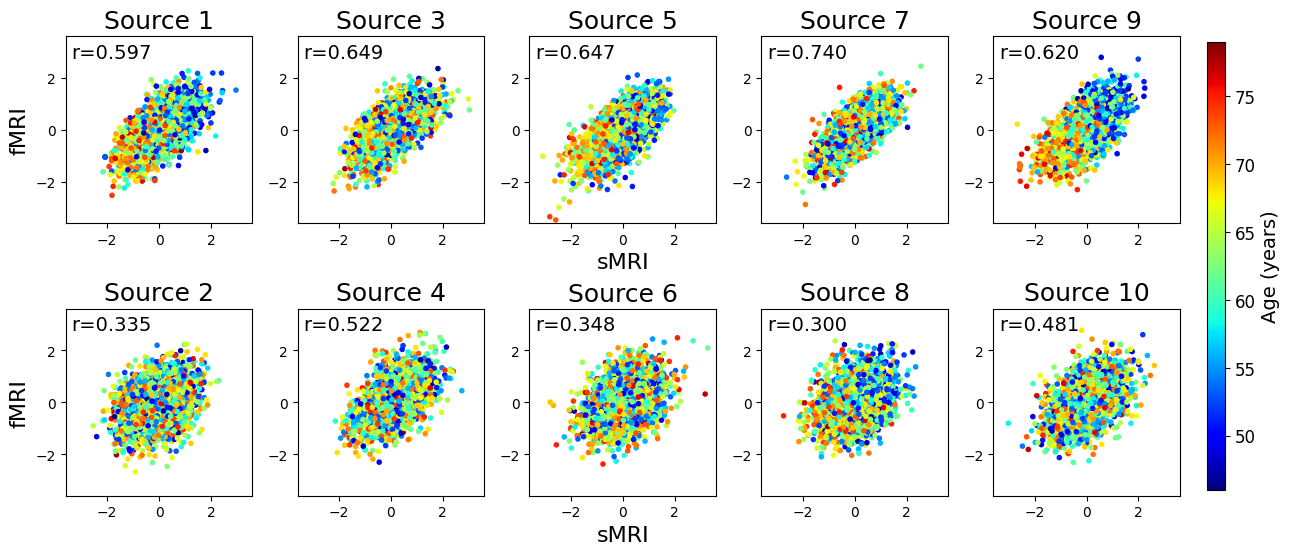

In [48]:
cmap = plt.cm.jet
norm = Normalize(vmin=age.min(), vmax=age.max())

lim = 3.6
fig, axes = plt.subplots(2,5,figsize=(12,5.6))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]
        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
        axes[i,k].set_aspect('equal', 'box')
        if k == 2:
            axes[i,k].set_xlabel('sMRI', fontsize=16)
        if k == 0:
            axes[i,k].set_ylabel('fMRI', fontsize=16)
        axes[i,k].set_title(f'Source {2*k+i+1}', fontsize=18)
        axes[i,k].set_xlim([-lim,lim])
        axes[i,k].set_ylim([-lim,lim])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        axes[i,k].annotate(f'r={r}', xy=(62, 130), xycoords='axes points',
            size=14, ha='right', va='top')
        age_subplot = axes[i,k].scatter(WAY1[i], WAY2[i], c=age, cmap=cmap, norm=norm, marker='.', alpha=1)

cbar_ax = fig.add_axes([1.01, 0.12, 0.015, 0.8])
cbar = plt.colorbar(age_subplot, cax=cbar_ax)
cbar.set_label('Age (years)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
# plt.savefig("figures/cca_age_ukb.png", bbox_inches='tight', dpi=2000)

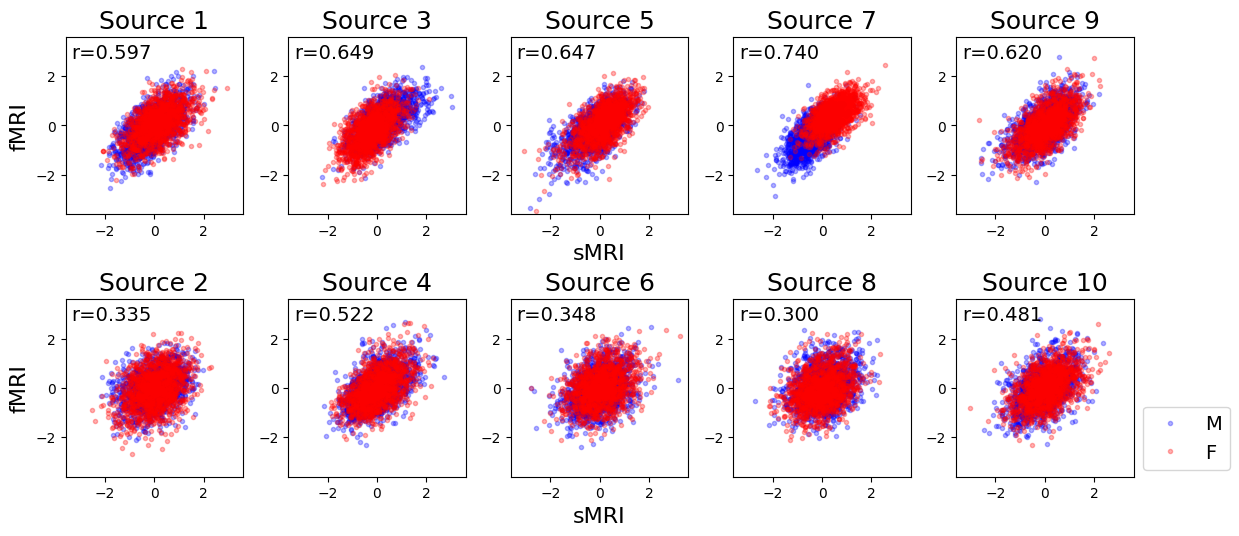

In [49]:
lim = 3.6
fig, axes = plt.subplots(2,5,figsize=(12.5,5.4))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]
        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
        axes[i,k].set_aspect('equal', 'box')
        if k == 2:
            axes[i,k].set_xlabel('sMRI', fontsize=16)
        if k == 0:
            axes[i,k].set_ylabel('fMRI', fontsize=16)
        axes[i,k].set_title(f'Source {2*k+i+1}', fontsize=18)
        axes[i,k].set_xlim([-lim,lim])
        axes[i,k].set_ylim([-lim,lim])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        axes[i,k].annotate(f'r={r}', xy=(62, 123), xycoords='axes points',
            size=14, ha='right', va='top')
        axes[i,k].plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3,label='M')
        axes[i,k].plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3,label='F')

axes[1,4].legend(bbox_to_anchor=(1, 0.45), fontsize=14)

plt.tight_layout()
# plt.savefig("figures/cca_sex_ukb.png", bbox_inches='tight', dpi=2000)

/var/folders/5j/0hyql0bn3xj4gszvbk8p05sr0000gq/T/ipykernel_35878/1374124973.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


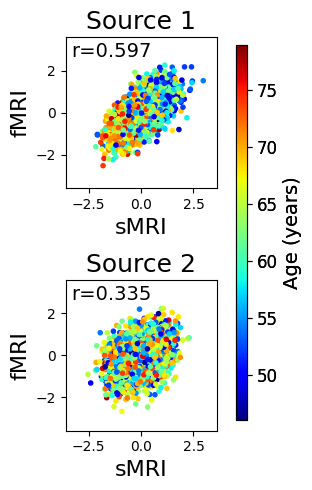

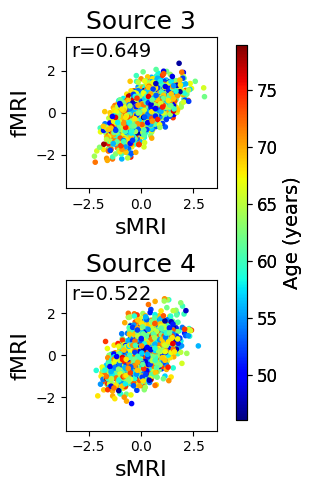

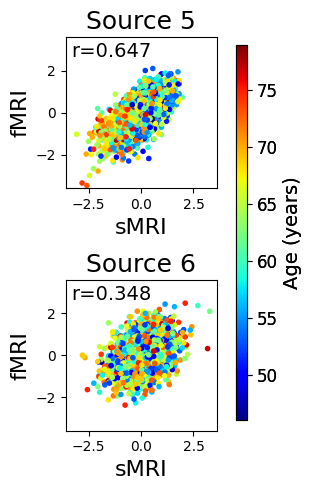

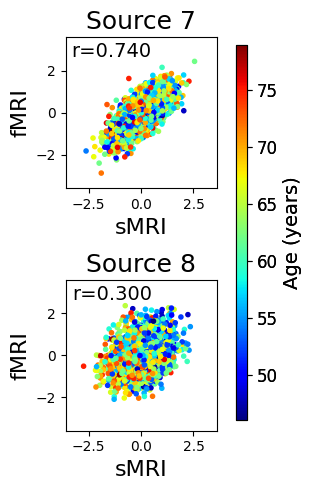

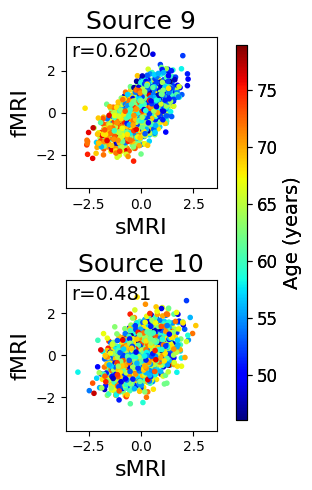

In [72]:
for k in range(5):
    fig, axes = plt.subplots(2,1,figsize=(2.8,5))
    for i in range(2):
        ax = axes[i]
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]
        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
        ax.set_aspect('equal', 'box')
        ax.set_xlabel('sMRI', fontsize=16)
        ax.set_ylabel('fMRI', fontsize=16)
        ax.set_title(f'Source {2*k+i+1}', fontsize=18)
        ax.set_xlim([-lim,lim])
        ax.set_ylim([-lim,lim])
        r = format(round(cca_corr_list[k][i,i], 3), '.3f')
        ax.annotate(f'r={r}', xy=(62, 105), xycoords='axes points',
            size=14, ha='right', va='top')
        age_subplot = ax.scatter(WAY1[i], WAY2[i], c=age, cmap=cmap, norm=norm, marker='.', alpha=1)
        cbar_ax = fig.add_axes([0.9, 0.15, 0.04, 0.75])
        cbar = plt.colorbar(age_subplot, cax=cbar_ax)
        cbar.set_label('Age (years)', fontsize=14)
        cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    # plt.savefig(f"figures/cca_map/cca_age_ukb_subspace{k+1}.png", bbox_inches='tight', dpi=500)

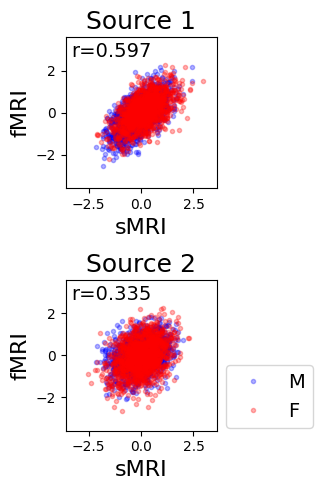

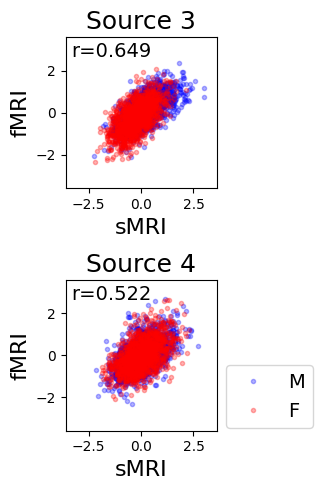

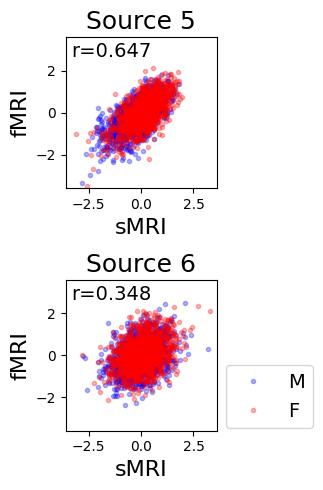

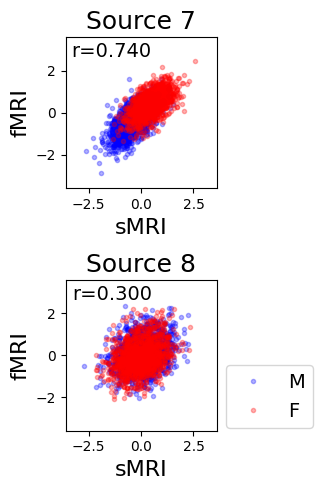

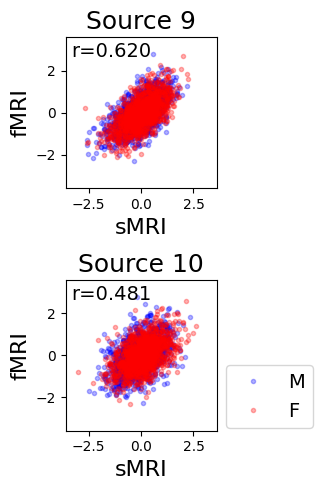

In [71]:
for k in range(5):
    fig, axes = plt.subplots(2,1,figsize=(3,5))
    for i in range(2):
        ax = axes[i]
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]
        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
        ax.set_aspect('equal', 'box')
        ax.set_xlabel('sMRI', fontsize=16)
        ax.set_ylabel('fMRI', fontsize=16)
        ax.set_title(f'Source {2*k+i+1}', fontsize=18)
        ax.set_xlim([-lim,lim])
        ax.set_ylim([-lim,lim])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        ax.annotate(f'r={r}', xy=(62, 105), xycoords='axes points',
            size=14, ha='right', va='top')
        ax.plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3,label='M')
        ax.plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3,label='F')
        if i == 1:
            ax.legend(bbox_to_anchor=(1, 0.5), fontsize=14)
    plt.tight_layout()
    # plt.savefig(f"figures/cca_map/cca_sex_ukb_subspace{k+1}.png", bbox_inches='tight', dpi=500)

In [10]:
regularizer_range = np.linspace(0.1, 1, 10)
param_grid_rr = [{'alpha': regularizer_range}]
param_grid_svm = [{'C': regularizer_range}]

for i in range(5):
    X12 = (np.concatenate((WAY_list[i][0], WAY_list[i][1]), axis=0)).T

    X_train, X_test, y_train, y_test = train_test_split(X12, age, test_size=0.312, random_state=42, stratify=age)
    base_estimator = Ridge()
    rr = GridSearchCV(base_estimator, param_grid_rr, cv=10).fit(X_train, y_train)
    mae = age_regression(X_train, X_test, y_train, y_test, a=rr.best_params_['alpha'])

    X_train, X_test, y_train, y_test = train_test_split(X12, sex, test_size=0.312, random_state=42, stratify=sex)
    base_estimator = LinearSVC(dual=False)
    svc = GridSearchCV(base_estimator, param_grid_svm, cv=10).fit(X_train, y_train)
    acc = sex_classification(X_train, X_test, y_train, y_test, c=svc.best_params_['C'])

    print(f"Subspace {i+1}: age regression MAE {mae:.3f}, sex classification accuracy {acc*100:.3f}")

Subspace 1: age regression MAE 5.674, sex classification accuracy 59.542
Subspace 2: age regression MAE 6.163, sex classification accuracy 64.496
Subspace 3: age regression MAE 5.892, sex classification accuracy 59.206
Subspace 4: age regression MAE 5.847, sex classification accuracy 79.933
Subspace 5: age regression MAE 5.378, sex classification accuracy 52.699


In [132]:
# M1-2, S1-5, median/young/old/male/female, voxel
age_median = np.median(age)
AY_median = np.zeros((2, 5, 5, 44318))
for s, i in enumerate(np.arange(0,10,2)):
    for m in range(2):
        Am = A[1,1,m,:,i:i+2]
        Ym = Y[1,1,m,i:i+2]
        AYm = Am@Ym
        AYm_young = AYm[:,age<age_median]
        AYm_old = AYm[:,age>=age_median]
        AYm_male = AYm[:,sex==0]
        AYm_female = AYm[:,sex==1]
        AYm_median = hd.geomedian(AYm,axis=1)
        AYm_young_median = hd.geomedian(AYm_young,axis=1)
        AYm_old_median = hd.geomedian(AYm_old,axis=1)
        AYm_male_median = hd.geomedian(AYm_male,axis=1)
        AYm_female_median = hd.geomedian(AYm_female,axis=1)
        AY_median[m,s,0] = AYm_median
        AY_median[m,s,1] = AYm_young_median
        AY_median[m,s,2] = AYm_old_median
        AY_median[m,s,3] = AYm_male_median
        AY_median[m,s,4] = AYm_female_median
sio.savemat("mat/AY_median_ukb.mat", {"AY_median": AY_median})

In [26]:
age_median = np.median(age)
AY_corr = np.zeros((5, 5, 44318))
p_value = np.zeros((5, 5, 44318))
for s, i in enumerate(np.arange(0,10,2)):
    A1 = A[1,1,0,:,i:i+2]
    Y1 = Y[1,1,0,i:i+2]
    A2 = A[1,1,1,:,i:i+2]
    Y2 = Y[1,1,1,i:i+2]
    AY1 = A1@Y1
    AY2 = A2@Y2
    for j in range(44318):
        AY_corr[s,0,j], p_value[s,0,j] = pearsonr(AY1[j], AY2[j])
        AY_corr[s,1,j], p_value[s,1,j] = pearsonr(AY1[j,age<age_median], AY2[j,age<age_median])
        AY_corr[s,2,j], p_value[s,2,j] = pearsonr(AY1[j,age>=age_median], AY2[j,age>=age_median])
        AY_corr[s,3,j], p_value[s,3,j] = pearsonr(AY1[j,sex==0], AY2[j,sex==0])
        AY_corr[s,4,j], p_value[s,4,j] = pearsonr(AY1[j,sex==1], AY2[j,sex==1])
sio.savemat("mat/AY_group_corr_ukb.mat", {"AY_corr": AY_corr})
sio.savemat("mat/AY_group_pvalue_ukb.mat", {"p_value": p_value})

In [73]:
age_median = np.median(age)
AY_corr = np.zeros((5, 5, 44318))
p_value = np.zeros((5, 5, 44318))
for s, i in enumerate(np.arange(0,10,2)):
    A1 = A[1,1,0,:,i:i+2]
    Y1 = Y[1,1,0,i:i+2]
    A2 = A[1,1,1,:,i:i+2]
    Y2 = Y[1,1,1,i:i+2]
    AY1 = A1@Y1
    AY2 = A2@Y2
    for j in range(44318):
        AY_corr[s,0,j], p_value[s,0,j] = pearsonr(AY1[j], AY2[j])
        AY_corr[s,1,j], p_value[s,1,j] = pearsonr(AY1[j,(age<age_median)&(sex==0)], AY2[j,(age<age_median)&(sex==0)])
        AY_corr[s,2,j], p_value[s,2,j] = pearsonr(AY1[j,(age<age_median)&(sex==1)], AY2[j,(age<age_median)&(sex==1)])
        AY_corr[s,3,j], p_value[s,3,j] = pearsonr(AY1[j,(age>=age_median)&(sex==0)], AY2[j,(age>=age_median)&(sex==0)])
        AY_corr[s,4,j], p_value[s,4,j] = pearsonr(AY1[j,(age>=age_median)&(sex==1)], AY2[j,(age>=age_median)&(sex==1)])
sio.savemat("mat/AY_group_corr_ukb_interaction.mat", {"AY_corr": AY_corr})
sio.savemat("mat/AY_group_pvalue_ukb_interaction.mat", {"p_value": p_value})

In [16]:
Xpath="/Users/xli77/Dropbox (GaTech)/MISA/MISA-data/sMRI-fMRI/X.mat"
X=sio.loadmat(Xpath)['X']
X=np.squeeze(X)

In [202]:
AY_corr = np.zeros((5, 44318))
for m in range(2):
    Xm = X[m]
    Xm_demean = Xm - np.mean(Xm)
    sstot = np.sum(Xm_demean**2)
    for s, i in enumerate(np.arange(0,10,2)):
        Am = A[1,1,m,:,i:i+2]
        Ym = Y[1,1,m,i:i+2]
        AYm = Am@Ym
        ssres = np.sum((Xm-AYm)**2)
        r2 = (1 - ssres/sstot)*100
        print(f"modality {m+1} subspace {s+1} variance explained: {r2:.3f}%")

modality 1 subspace 1 variance explained: 5.396%
modality 1 subspace 2 variance explained: 7.322%
modality 1 subspace 3 variance explained: 7.011%
modality 1 subspace 4 variance explained: 5.112%
modality 1 subspace 5 variance explained: 7.064%
modality 2 subspace 1 variance explained: 4.995%
modality 2 subspace 2 variance explained: 2.762%
modality 2 subspace 3 variance explained: 3.251%
modality 2 subspace 4 variance explained: 6.445%
modality 2 subspace 5 variance explained: 2.379%


In [34]:
def compute_coefficient_of_variation(m, i=8):
    Am = A[1,1,m,:,i:i+2]
    Ym = Y[1,1,m,i:i+2]
    AYm = Am@Ym
    AYm_std = np.std(AYm, axis=1)
    AYm_young = AYm[:,age<age_median]
    AYm_old = AYm[:,age>=age_median]
    AYm_young_median = hd.geomedian(AYm_young, axis=1)
    AYm_old_median = hd.geomedian(AYm_old, axis=1)
    group_diff = np.abs(np.array(AYm_young_median) - np.array(AYm_old_median))
    coeff_var = group_diff/AYm_std
    return coeff_var

coeff_var1 = compute_coefficient_of_variation(0)
coeff_var2 = compute_coefficient_of_variation(1)
coeff_var = np.maximum(coeff_var1, coeff_var2)
sio.savemat("mat/AY5_coeff_var_ukb.mat", {"coeff_var": coeff_var})